# Assignment 3  
Tiaab van Antwerpen  
23537027  

The kaggle datset used for this notebook was: [Adult income dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset?select=adult.csv)

About Dataset
An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.


Fields
The dataset contains 16 columns
Target filed: Income
-- The income is divide into two classes: <=50K and >50K
Number of attributes: 14
-- These are the demographics and other features to describe a person

We can explore the possibility in predicting income level based on the individual’s personal information.

https://iopscience.iop.org/article/10.1088/1755-1315/243/1/012111#:~:text=Na%C3%AFve%20Bayes%20Imputation%20(NBI)%20is,process%20at%20the%20lost%20value.  
https://iopscience.iop.org/article/10.1088/1755-1315/243/1/012111/pdf

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
from ydata_profiling import ProfileReport
%matplotlib inline

# Importing data

In [3]:
df = pd.read_csv("data/adult.csv")
df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

In [4]:
df = df.replace('?', np.nan)
df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18        NaN  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

### Data exploration

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

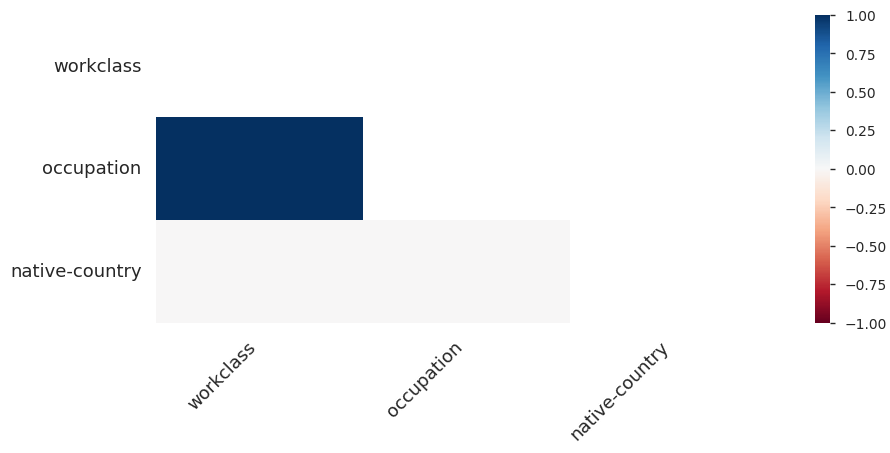

In [5]:
profile = ProfileReport(df, title="Profiling MPG Report")
profile.to_notebook_iframe()
profile.to_file("data-exploration/profiling_report.html")

### Data dict

.....describing features

### Data Cleaning

#### NAIVE Bayes Imputation (NBI)

Naïve Bayes Imputation (NBI) is used to fill in missing values by replacing the attribute information according to the probability estimate. The NBI process divides the whole data into two sub-sets is the complete data and data containing missing data. Complete data is used for the imputation process at the lost value

1. Split the Data: Divide the data into two subsets. One subset contains complete rows (no missing values), and the other contains rows with missing values.

2. Train Naïve Bayes Classifier: Train a Naïve Bayes classifier on the complete data. The classifier should be trained for each feature with missing values, using all other features as predictors.

3. Impute Missing Values: For each row in the incomplete data, use the trained Naïve Bayes classifier to predict the missing values.

4. Combine Data: Combine the complete and imputed data back together.

In [6]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load and prepare the data
df = pd.read_csv("data/adult.csv")
df.replace('?', None, inplace=True)  # Convert '?' to NaN

# Get list of categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Create a LabelEncoder object and a dictionary to store label encoders for each column
encoder_dict = {}

# Iterate over each categorical column
for column in categorical_columns:
    encoder = LabelEncoder()
    non_nulls = df[column].notna()
    df.loc[non_nulls, column] = encoder.fit_transform(df.loc[non_nulls, column])
    df[column] = pd.to_numeric(df[column])
    encoder_dict[column] = encoder  # Store the encoder

#print(df)
# List of features to impute
features_to_impute = ['workclass', 'occupation', 'native-country']

for feature in features_to_impute:
    # Identify columns without any missing values to use in training
    non_missing_columns = df.columns[df.notna().all()]

    # Prepare the training data: drop rows where the feature is NaN
    training_data = df.dropna(subset=[feature])

    # Prepare the training set
    # Exclude the feature to impute, 'income', and any columns that still have missing data
    X_train = training_data[non_missing_columns]#.drop(columns=['income'])
    y_train = training_data[feature]

    # Train the Gaussian Naive Bayes classifier
    model = GaussianNB(var_smoothing=1e-9)
    model.fit(X_train, y_train)

    # Prepare data for prediction: select rows where the feature is NaN
    missing_data = df[df[feature].isna()]
    if not missing_data.empty:
        # Predict the missing values
        predicted_values = model.predict(missing_data[X_train.columns])
        df.loc[df[feature].isna(), feature] = predicted_values

# Convert the numeric data back to their original categories
for column in categorical_columns:
    encoder = encoder_dict[column]
    valid_idx = df[column].notna()
    # Ensure that the column is ready to receive string data
    df[column] = df[column].astype('object')
    if not df[valid_idx].empty:
        df.loc[valid_idx, column] = encoder.inverse_transform(df.loc[valid_idx, column].astype(int))


# Output the DataFrame and check remaining missing values
print(df)
print("\nNaN values at the end in each column:")
print(df.isna().sum())

NBI_df = df

       age     workclass  fnlwgt     education  educational-num  \
0       25       Private  226802          11th                7   
1       38       Private   89814       HS-grad                9   
2       28     Local-gov  336951    Assoc-acdm               12   
3       44       Private  160323  Some-college               10   
4       18  Never-worked  103497  Some-college               10   
...    ...           ...     ...           ...              ...   
48837   27       Private  257302    Assoc-acdm               12   
48838   40       Private  154374       HS-grad                9   
48839   58       Private  151910       HS-grad                9   
48840   22       Private  201490       HS-grad                9   
48841   52  Self-emp-inc  287927       HS-grad                9   

           marital-status         occupation relationship   race  gender  \
0           Never-married  Machine-op-inspct    Own-child  Black    Male   
1      Married-civ-spouse    Farming-fishin

## Mode imputation method

In [7]:
import pandas as pd

# Load and prepare the data
df = pd.read_csv("data/adult.csv")
df.replace('?', pd.NA, inplace=True)  # Convert '?' to pd.NA (which is better for representing missing values than None)

# Get list of columns with missing data
features_to_impute = df.columns[df.isna().any()].tolist()

# Perform mode imputation
for feature in features_to_impute:
    mode_value = df[feature].mode()[0]
    df[feature] = df[feature].fillna(mode_value)  # Assign the filled series back to the DataFrame

# Output the DataFrame and check remaining missing values
print(df.head(10))
print("\nNaN values at the end in each column:")
print(df.isna().sum())

mode_impute_df = df


   age         workclass  fnlwgt     education  educational-num  \
0   25           Private  226802          11th                7   
1   38           Private   89814       HS-grad                9   
2   28         Local-gov  336951    Assoc-acdm               12   
3   44           Private  160323  Some-college               10   
4   18           Private  103497  Some-college               10   
5   34           Private  198693          10th                6   
6   29           Private  227026       HS-grad                9   
7   63  Self-emp-not-inc  104626   Prof-school               15   
8   24           Private  369667  Some-college               10   
9   55           Private  104996       7th-8th                4   

       marital-status         occupation   relationship   race  gender  \
0       Never-married  Machine-op-inspct      Own-child  Black    Male   
1  Married-civ-spouse    Farming-fishing        Husband  White    Male   
2  Married-civ-spouse    Protective-serv

## Machine learning model to compare results

In [8]:
# Feature Selection and Encoding
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split #training and testing data split

In [9]:
NBI_df = NBI_df.apply(LabelEncoder().fit_transform)
NBI_df.head()

age  workclass  fnlwgt  education  educational-num  marital-status  \
0    8          3   19329          1                6               4   
1   21          3    4212         11                8               2   
2   11          1   25340          7               11               2   
3   27          3   11201         15                9               2   
4    1          2    5411         15                9               4   

   occupation  relationship  race  gender  capital-gain  capital-loss  \
0           6             3     2       1             0             0   
1           4             0     4       1             0             0   
2          10             0     4       1             0             0   
3           6             0     2       1            98             0   
4           7             3     4       0             0             0   

   hours-per-week  native-country  income  
0              39              38       0  
1              49              38       0  
2              39              38       1  
3              39              38       1  
4              29              38       0

In [10]:
#drop_elements = ['education', 'native-country', 'income', 'age_bin', 'age-hours_bin','hours-per-week_bin']
drop_elements = ['income']
y = NBI_df["income"]
X = NBI_df.drop(drop_elements, axis=1)
X.head()

age  workclass  fnlwgt  education  educational-num  marital-status  \
0    8          3   19329          1                6               4   
1   21          3    4212         11                8               2   
2   11          1   25340          7               11               2   
3   27          3   11201         15                9               2   
4    1          2    5411         15                9               4   

   occupation  relationship  race  gender  capital-gain  capital-loss  \
0           6             3     2       1             0             0   
1           4             0     4       1             0             0   
2          10             0     4       1             0             0   
3           6             0     2       1            98             0   
4           7             3     4       0             0             0   

   hours-per-week  native-country  
0              39              38  
1              49              38  
2              39              38  
3              39              38  
4              29              38

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

PCA

In [12]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

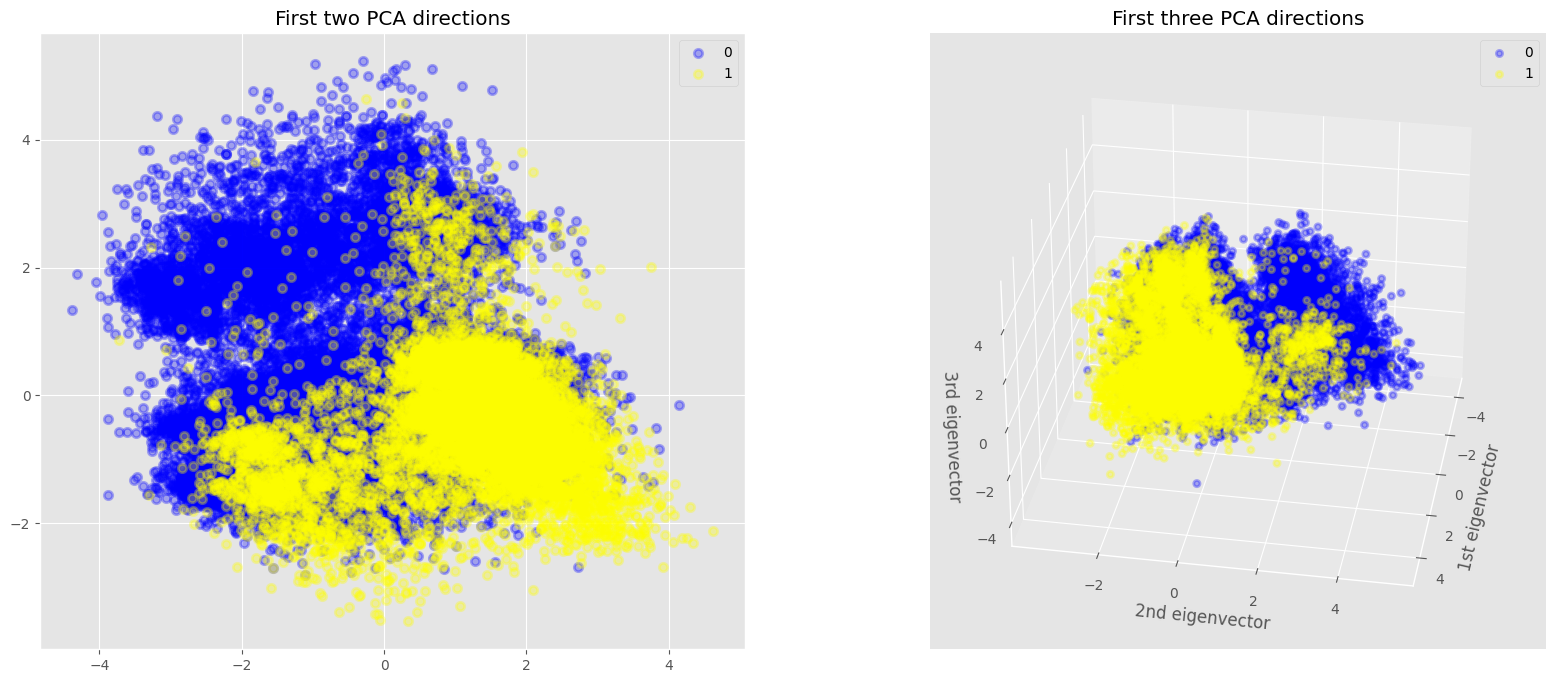

In [13]:
# PCA's components graphed in 2D and 3D
# Apply Scaling 
std_scale = preprocessing.StandardScaler().fit(NBI_df.drop('income', axis=1))
X = std_scale.transform(NBI_df.drop('income', axis=1))
y = NBI_df['income']

# Formatting
target_names = [0,1]
colors = ['blue','yellow','pink']
lw = 2
alpha = 0.3
# 2 Components PCA
# plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

In [14]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
pca = PCA(n_components=None)
x_train_pca = pca.fit_transform(X_train_std)
a = pca.explained_variance_ratio_
a_running = a.cumsum()
a_running

array([0.15047723, 0.25243708, 0.33414165, 0.413467  , 0.48857071,
       0.56235437, 0.63197433, 0.69975665, 0.76189023, 0.82239988,
       0.88187003, 0.93039831, 0.97249723, 1.        ])

### Classification model

Linear Support Vector Machine

In [19]:
# # Support Vector Classifier (SVM/SVC)
# from sklearn.svm import SVC
# svc = SVC(gamma=0.22)
# svc.fit(X_train, y_train)
# #y_pred = logreg.predict(X_test)
# score_svc = svc.score(X_test,y_test)
# print('The accuracy of SVC is', score_svc)

Radical Support Vector Machine

In [20]:
# from sklearn.svm import SVC
# svc_radical = SVC(kernel='rbf', C=1, gamma=0.22)
# svc_radical.fit(X_train, y_train.values.ravel())
# score_svc_radical = svc_radical.score(X_test, y_test)
# print('The accuracy of Radical SVC Model is', score_svc_radical)

Random forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
#y_pred = randomforest.predict(X_test)
score_randomforest = randomforest.score(X_test,y_test)
print('The accuracy of the Random Forest Model is', score_randomforest)

The accuracy of the Random Forest Model is 0.8527996724332071


K-nearest Neighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)
score_knn = knn.score(X_test,y_test)
print('The accuracy of the KNN Model is',score_knn)

The accuracy of the KNN Model is 0.7782782270447334


Cross validation

In [ ]:
### cross validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Naive Bayes','Linear Svm','Radial Svm','Logistic Regression','Decision Tree','KNN','Random Forest']
models=[GaussianNB(), svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),DecisionTreeClassifier(),
        KNeighborsClassifier(n_neighbors=9),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
models_dataframe=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
models_dataframe